In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

## account for the folder structure 
import sys
sys.path.append(os.path.abspath("../scr"))

from helper.plot import plot_adj_matrix

import wandb 

In [3]:
args = {
    "model_type": "IPC",
    # "graph_type": "fully_connected",  # Type of graph
    "update_rules": "Van_Zwol",  # Update rules for learning

    "graph_type": "single_hidden_layer",  # Type of graph
    "discriminative_hidden_layers": [32, 16],  # Hidden layers for discriminative model
    "generative_hidden_layers": [0],  # Hidden layers for generative model

    "delta_w_selection": "all",  # Selection strategy for weight updates
    "weight_init": "fixed 0.001 0.001",  # Weight initialization method
    "use_grokfast": True,  # Whether to use GrokFast
    "optimizer": 1.0,  # Optimizer setting
    "remove_sens_2_sens": True,  # Remove sensory-to-sensory connections
    "remove_sens_2_sup": True,  # Remove sensory-to-supervised connections
    "set_abs_small_w_2_zero": False,  # Set small absolute weights to zero
    "mode": "experimenting",  # Mode of operation (training/experimenting)
    "use_wandb": "offline",  # WandB logging mode
    "tags": "PC_vs_IPC",  # Tags for logging
    "use_bias": False,  # Whether to use bias
    "normalize_msg": False,  # Normalize message passing
    "dataset_transform": ["normalize_mnist_mean_std"],  # Data transformations
    "numbers_list": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # Classes to include
    "N": "all",  # Number of samples per class
    "supervision_label_val": 1,  # Value assigned for supervision
    "num_internal_nodes": 1000,  # Number of internal nodes in the network
    "T": 5,  # Number of inference iterations
    "lr_values": 0.01,  # Learning rate for value updates
    "lr_weights": 0.00001,  # Learning rate for weight updates
    "activation_func": "swish",  # Activation function
    "epochs": 10,  # Number of training epochs
    "batch_size": 10,  # Batch size for training
    "seed": 2,  # Random seed
}

In [4]:
# args = {
#     "model_type": "IPC",
#     # "graph_type": "fully_connected",  # Type of graph
#     "update_rules": "Van_Zwol",  # Update rules for learning

#     "graph_type": "fully_connected",  # Type of graph
#     "discriminative_hidden_layers": None,  # Hidden layers for discriminative model
#     "generative_hidden_layers": None,  # Hidden layers for generative model

#     "delta_w_selection": "all",  # Selection strategy for weight updates
#     "weight_init": "fixed 0.001 0.001",  # Weight initialization method
#     "use_grokfast": True,  # Whether to use GrokFast
#     "optimizer": 1.0,  # Optimizer setting
#     "remove_sens_2_sens": True,  # Remove sensory-to-sensory connections
#     "remove_sens_2_sup": True,  # Remove sensory-to-supervised connections
#     "set_abs_small_w_2_zero": False,  # Set small absolute weights to zero
#     "mode": "experimenting",  # Mode of operation (training/experimenting)
#     "use_wandb": "offline",  # WandB logging mode
#     "tags": "PC_vs_IPC",  # Tags for logging
#     "use_bias": False,  # Whether to use bias
#     "normalize_msg": False,  # Normalize message passing
#     "dataset_transform": ["normalize_mnist_mean_std"],  # Data transformations
#     "numbers_list": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # Classes to include
#     "N": "all",  # Number of samples per class
#     "supervision_label_val": 1,  # Value assigned for supervision
#     "num_internal_nodes": 1000,  # Number of internal nodes in the network
#     "T": 5,  # Number of inference iterations
#     "lr_values": 0.01,  # Learning rate for value updates
#     "lr_weights": 0.00001,  # Learning rate for weight updates
#     "activation_func": "swish",  # Activation function
#     "epochs": 10,  # Number of training epochs
#     "batch_size": 10,  # Batch size for training
#     "seed": 2,  # Random seed
# }

In [5]:



# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument


class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)


# Make True of False bool
args.normalize_msg = args.normalize_msg == 'True'
args.use_bias = args.use_bias == 'True'
args.set_abs_small_w_2_zero = args.set_abs_small_w_2_zero == 'True'
args.grokfast = args.use_grokfast == 'True'

tags_list = args.tags.split(",") if args.tags else []


['normalize_mnist_mean_std']


### STEPS:

- Create graph topology (Fully_connc, hierachy, SBM)
- Create datasets (MNIST)
-  
- ... 

Using device: cpu
Seed used 2
Device name:  NVIDIA GeForce MX130
zzz True True
graph_params 1 : {'internal_nodes': 48, 'supervised_learning': True, 'graph_type': {'name': 'single_hidden_layer', 'params': {'remove_sens_2_sens': True, 'remove_sens_2_sup': True, 'discriminative_hidden_layers': [32, 16], 'generative_hidden_layers': [0]}}, 'seed': 2}
graph_params {'internal_nodes': 48, 'supervised_learning': True, 'graph_type': {'name': 'single_hidden_layer', 'params': {'remove_sens_2_sens': True, 'remove_sens_2_sup': True, 'discriminative_hidden_layers': [32, 16], 'generative_hidden_layers': [0]}}, 'seed': 2}
Setting seed: 2
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
{'remove_sens_2_sens': True, 'remove_sens_2_sup': True, 'discriminative_hidden_layers': [32, 16], 'generative_hidden_layers': [0]}
Creating graph structure for single_hidden_layer
Custom graph with shared internal nod

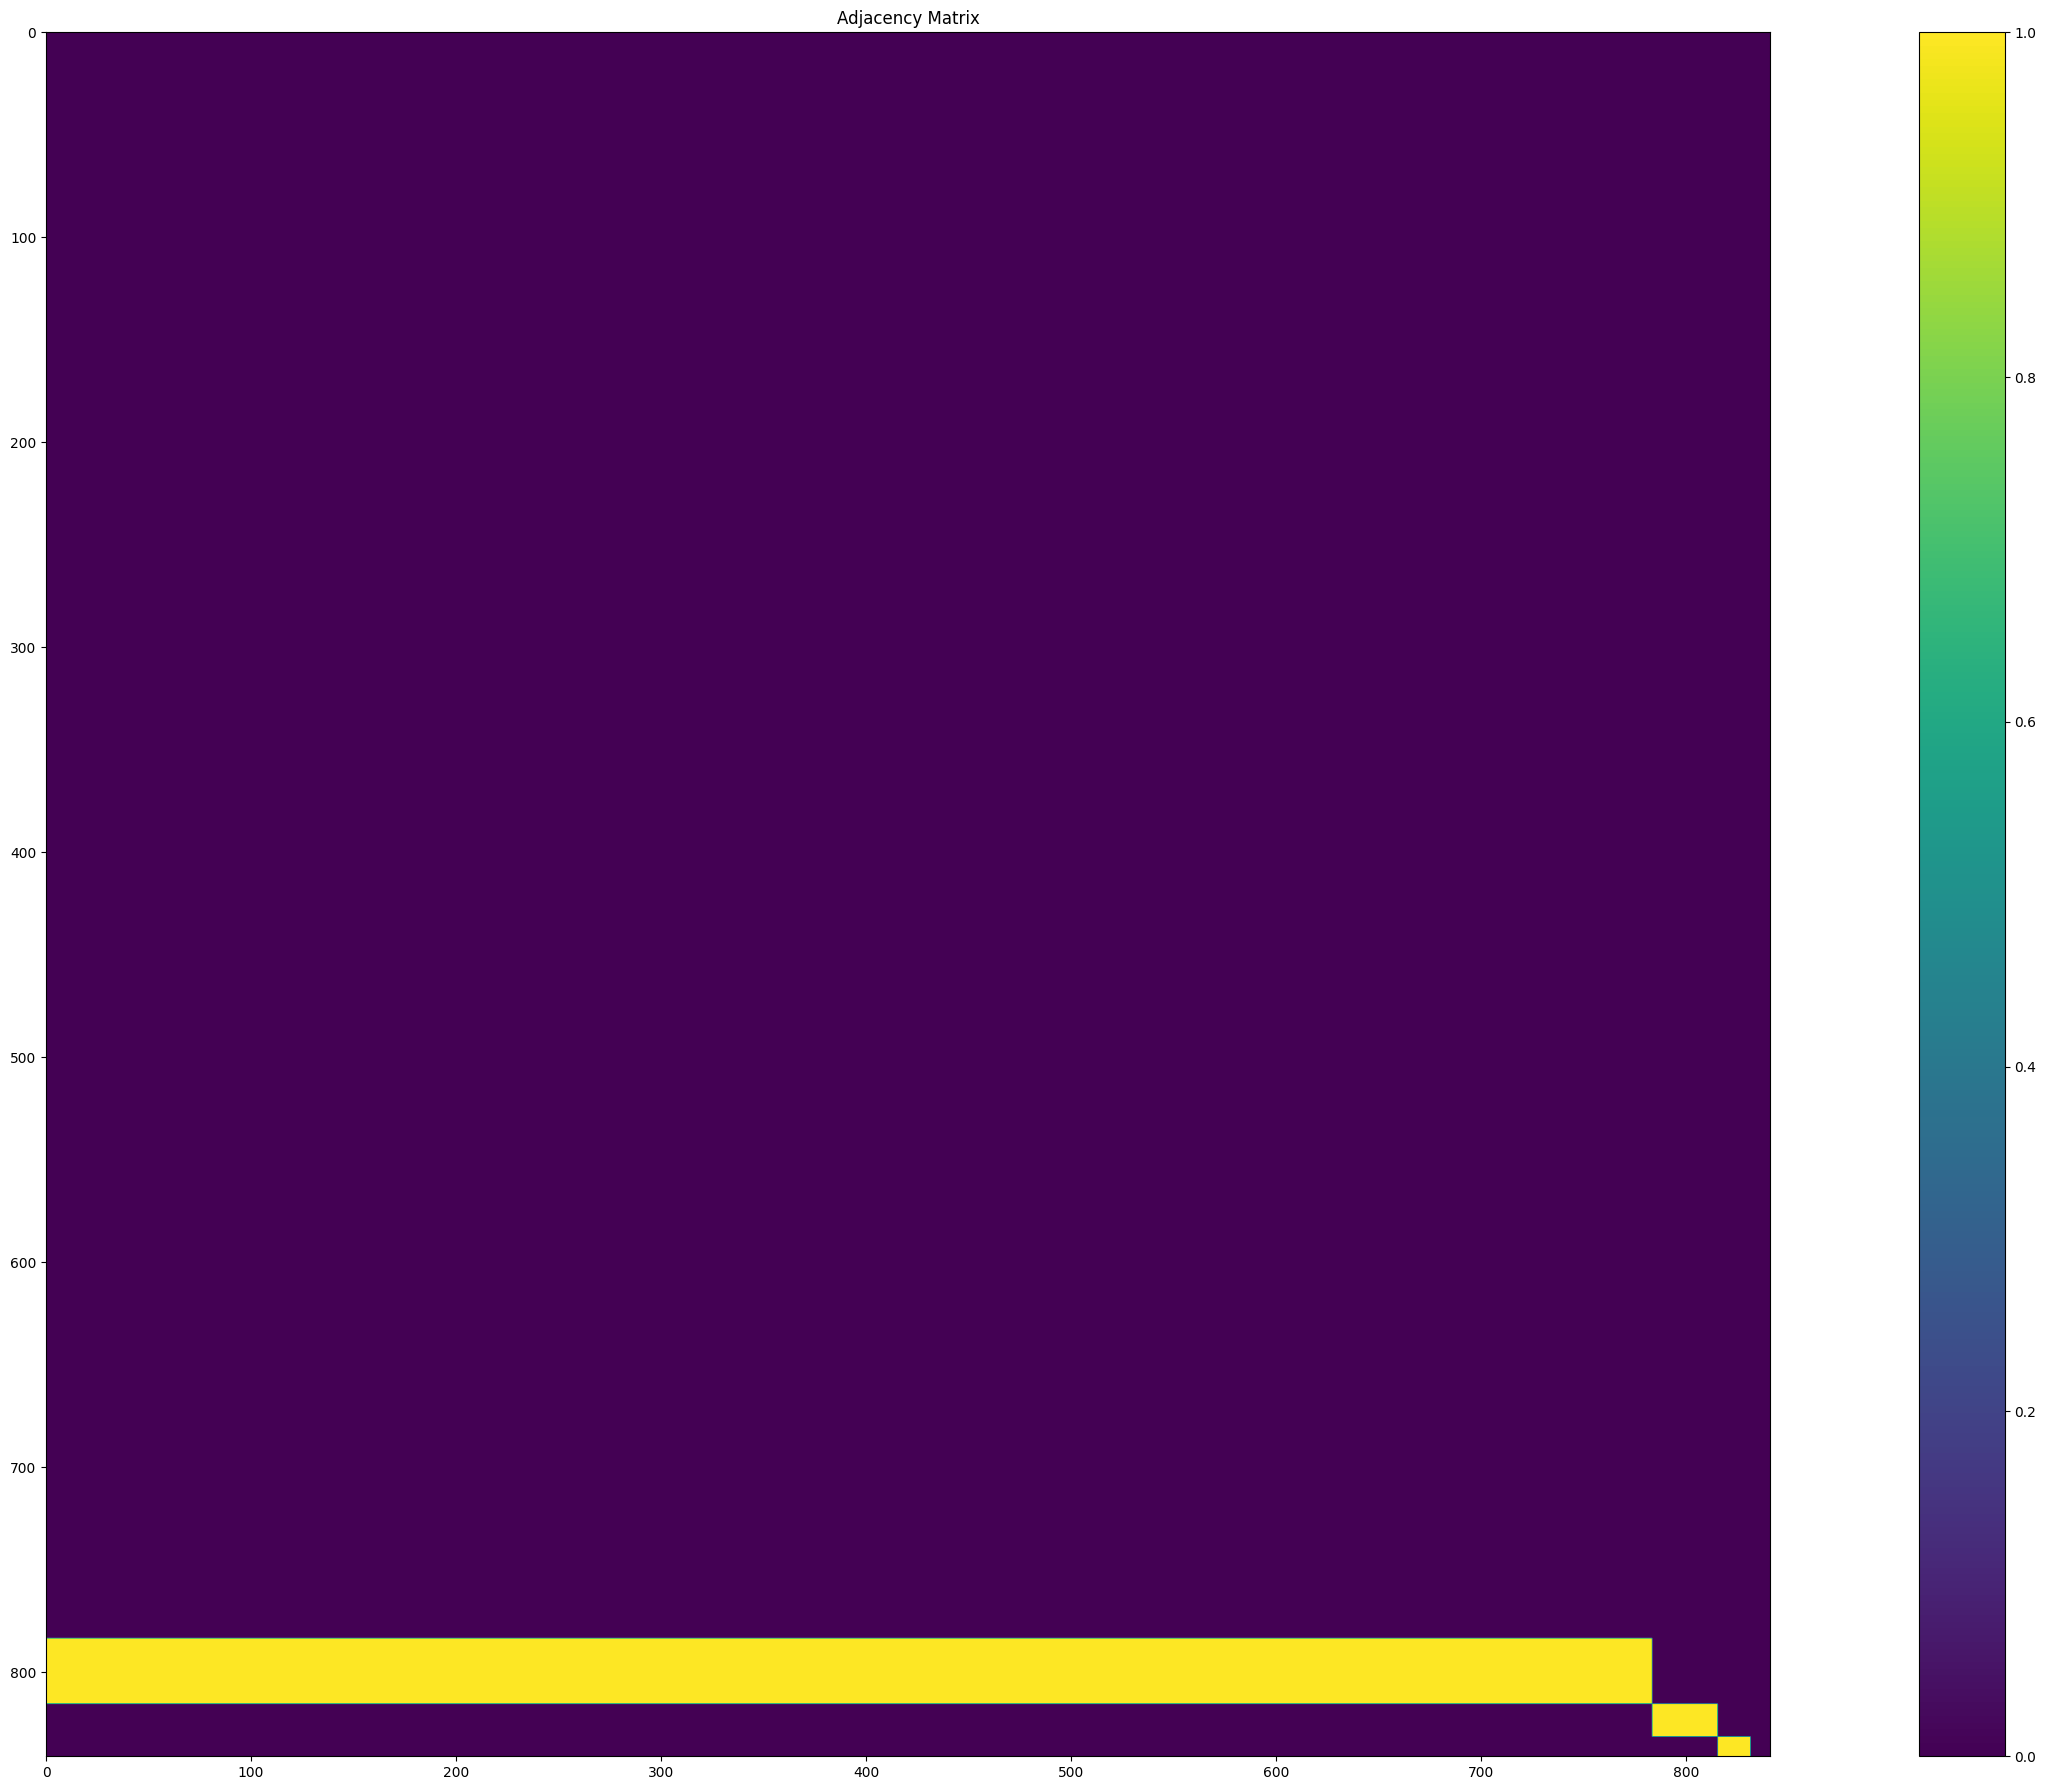

In [6]:



# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# force cpu
device = torch.device('cpu')

print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)



######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"
    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"], 
        # "params_general": {
        #     "remove_sens_2_sens": args.remove_sens_2_sens,  # Set from command line
        #     "remove_sens_2_sup": args.remove_sens_2_sup,    # Set from command line
        #     },
        },  
    "seed": args.seed,   
}

print("zzz", args.remove_sens_2_sens, args.remove_sens_2_sup)
graph_params["graph_type"]["params"]["remove_sens_2_sens"] = args.remove_sens_2_sens  
graph_params["graph_type"]["params"]["remove_sens_2_sup"]  = args.remove_sens_2_sup 


if graph_params["graph_type"]["name"] == "stochastic_block":
    
    # override internal nodes if doing clustering
    graph_params["internal_nodes"] = (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

if graph_params["graph_type"]["name"] == "stochastic_block_hierarchy":
    # Configure internal nodes for stochastic_block_hierarchy
    # Define the hierarchical structure with two layers and a final layer
    layer_1_clusters = 49  # First layer has 49 clusters (7x7 grid of 4x4 blocks)
    clusters_per_layer = layer_1_clusters
    num_layers = 2  # Only two layers before the final layer
    final_layer_clusters = 10  # Number of clusters in the final layer

    # Calculate the total internal nodes across the layers
    # - `clusters_per_layer * 16` accounts for the 4x4 nodes per cluster in each layer
    # - The final layer has `final_layer_clusters` nodes
    graph_params["internal_nodes"] = (clusters_per_layer * 16 * num_layers) + final_layer_clusters


if graph_params["graph_type"]["name"] == "two_branch_graph":
    # Configure internal nodes for two_branch_graph
    # This assumes two branches with specified configurations
    branch1_layers, branch1_clusters_per_layer, branch1_nodes_per_cluster = graph_params["branch1_config"]
    branch2_layers, branch2_clusters_per_layer, branch2_nodes_per_cluster = graph_params["branch2_config"]
    
    # Calculate total internal nodes for both branches
    # Branch 1
    branch1_internal_nodes = branch1_layers * branch1_clusters_per_layer * branch1_nodes_per_cluster
    # Branch 2 (Reversed order)
    branch2_internal_nodes = branch2_layers * branch2_clusters_per_layer * branch2_nodes_per_cluster
    
    # The total number of internal nodes will be the sum of both branches
    graph_params["internal_nodes"] = branch1_internal_nodes + branch2_internal_nodes


if graph_params["graph_type"]["name"] in ["single_hidden_layer"]:

    
    # # discriminative_hidden_layers = [0]  # Adjust if layers change
    # generative_hidden_layers = [50, 100, 200] # Adjust if layers change
    
    # # Calculate total number of nodes
    # discriminative_hidden_layers = [200, 100, 50]  # Adjust if layers change
    # # generative_hidden_layers = [0] # Adjust if layers change

    discriminative_hidden_layers = args.discriminative_hidden_layers or [200, 100, 50]  # Default if not provided
    generative_hidden_layers = args.generative_hidden_layers or [50, 100, 200]  # Default if not provided


    num_discriminative_nodes = sum(discriminative_hidden_layers)
    num_generative_nodes = sum(generative_hidden_layers)

    graph_params["graph_type"]["params"]["discriminative_hidden_layers"] = discriminative_hidden_layers
    graph_params["graph_type"]["params"]["generative_hidden_layers"]  = generative_hidden_layers
   
    graph_params["internal_nodes"] = num_discriminative_nodes + num_generative_nodes

    # edge_index, N = test_single_hidden_layer(discriminative_hidden_layers, generative_hidden_layers,
    #                                         no_sens2sens=True, no_sens2supervised=True)

    if sum(discriminative_hidden_layers) == 0:
        eval_classification = False
    if sum(generative_hidden_layers) == 0:
        eval_generation = False

    # TODO ; still unsure about which graph does which task
    eval_generation, eval_classification, eval_denoise, eval_occlusion = True, True, 0, 0 

if graph_params["graph_type"]["name"] not in ["single_hidden_layer"]:
    # Ensure these arguments are not specified for other graph types
    assert args.discriminative_hidden_layers is None, \
        "The argument --discriminative_hidden_layers can only be used if graph_type is 'single_hidden_layer'."
    assert args.generative_hidden_layers is None, \
        "The argument --generative_hidden_layers can only be used if graph_type is 'single_hidden_layer'."

# if graph_params["graph_type"]["name"] in ["custom_two_branch", "two_branch_graph"]:
#     # Configure internal nodes for two_branch_graph
#     # This assumes two branches with specified configurations
#     branch1_config = graph_params["graph_type"]["params"]["branch1_config"]
#     branch2_config = graph_params["graph_type"]["params"]["branch2_config"]
    
#     # Calculate total internal nodes for both branches
#     # Sum up the total internal nodes for Branch 1
#     branch1_internal_nodes = sum([clusters * nodes_per_cluster for clusters, nodes_per_cluster in branch1_config])
    
#     # Sum up the total internal nodes for Branch 2 (Reversed order if required)
#     branch2_internal_nodes = sum([clusters * nodes_per_cluster for clusters, nodes_per_cluster in branch2_config])
    
#     # The total number of internal nodes will be the sum of both branches
#     graph_params["internal_nodes"] = branch1_internal_nodes + branch2_internal_nodes

print("graph_params 1 :", graph_params)

from graphbuilder import GraphBuilder

print("graph_params", graph_params)
graph = GraphBuilder(**graph_params)


single_graph = graph.edge_index

adj_matrix_pyg = plot_adj_matrix(single_graph, model_dir=None, node_types=None)


In [7]:



# # from dataset import CustomGraphDataset
# from dataset_vanZwol import PCGraphDataset


# # Initialize the GraphBuilder
# custom_dataset_train = PCGraphDataset(graph_params, **dataset_params)


# dataset_params["batch_size"] = args.batch_size
# dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# # dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

# print("Device \t\t\t:", device)
# print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


# from helper.plot import plot_adj_matrix

# single_graph = custom_dataset_train.edge_index


# # print("--------------Init DataLoader --------------------")
# # train_loader = DataLoader(custom_dataset_train, 
# #                           batch_size=dataset_params["batch_size"], 
# #                           shuffle=True, 
# #                           generator=generator_seed,
# #                           num_workers=1
# #                           )




# NUM_SENSORY = 28*28  # 10

# ## TODO: FIX HOW TO DO THIS 
# #### ---------------------------------------------------------------------------------------------------------------
# # sensory_indices    = range(NUM_SENSORY)
# # internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# # num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# # supervision_indices = None

# # if dataset_params["supervised_learning"]:
# #     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
# #     supervision_indices = label_indices
# #     num_vertices += 10

# # print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# # print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# # print("num_vertices \t\t:", num_vertices)

# # if dataset_params["supervised_learning"]:
# #   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# # else:
# #   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
# #### ---------------------------------------------------------------------------------------------------------------

# num_vertices = custom_dataset_train.num_vertices
# sensory_indices = custom_dataset_train.sensory_indices
# internal_indices = custom_dataset_train.internal_indices
# supervision_indices = custom_dataset_train.supervision_indices



# # print(train_loader.batch_size)
# # for batch, clean_image in train_loader:
    
# #     values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
# #     x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
# #     print("edge_index", edge_index.shape)

# #     print(batch.x[:, 0].shape)
# #     print(custom_dataset_train.edge_index.shape)
    

# #     full_batch = edge_index

# #     break




# ######################################################################################################### 
# ####                                            VALIDATION                                          #####
# ######################################################################################################### 
 
# # from helper.validate_MP import validate_messagePassing
# # validate_messagePassing()

# ######################################################################################################### 
# ####                                            FIND OPTIMAL LR                                     #####
# ######################################################################################################### 
# """ 
# SKIPPING FOR NOW, see local  
# """



# ######################################################################################################### 
# ####                                              Model  (setup)                                    #####
# ######################################################################################################### 

# # lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# # lr_gamma, lr_alpha =  (0.1, 0.00001)

# model_params = {
#     'num_vertices': num_vertices,
#     'sensory_indices': (sensory_indices), 
#     'internal_indices': (internal_indices), 
#     "supervised_learning": (supervision_indices),

#     "lr_params": (args.lr_values, args.lr_weights),
#     #   (args.lr_gamma, args.lr_alpha), 
#     "T": args.T,
#     "graph_structure": custom_dataset_train.edge_index_tensor, 
#     "batch_size": args.batch_size, 
#     'edge_type': custom_dataset_train.edge_type, 
#     "use_bias": args.use_bias,
 
#     "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
#     # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
#     "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
#     "activation": args.activation_func,  
#     "clamping": None , # (0, torch.inf) or 'None' 

#     "normalize_msg": args.normalize_msg,
#  }

# learning_params = model_params.copy()
# learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
# learning_params['internal_indices'] = list(learning_params['internal_indices'])
# learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# # learning_params['transform'] = transform.to_dict()["transform"]
# learning_params['dataset_transform'] = args.dataset_transform

# learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

# model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

# def default(obj):
#     if type(obj).__module__ == np.__name__:
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         else:
#             return obj.item()
    
#     raise TypeError('Unknown type:', type(obj))

# # combi of learning params and dataset params
# params_dict = {**dataset_params, **learning_params}


# import json

# from datetime import datetime




# save_model_params = False

# # plot_adj_matrix(single_graph, model_dir, 
# #                 node_types=(sensory_indices, internal_indices, supervision_indices))
# # plot_adj_matrix(full_batch, model_dir, node_types=None)


In [8]:


# from dataset import CustomGraphDataset
from dataset_vanZwol import PCGraphDataset, train_subset_indices


# # Initialize the GraphBuilder
# custom_dataset_train = PCGraphDataset(graph_params, **dataset_params)



In [9]:
from torch_geometric.data import Batch

def custom_collate_fn(batch):

    # batched_data = Data.from_batch(batch)  # Use the built-in PyG batching method
    batched_data = Batch.from_data_list(batch)

    sensory_indices = []
    internal_indices = []
    supervision_indices = []

    node_offset = 0  # Keeps track of node offset as we batch graphs

    for data in batch:
        # Adjust the indices by adding the current node offset
        sensory_indices.append(data.sensory_indices + node_offset)
        internal_indices.append(data.internal_indices + node_offset)
        supervision_indices.append(data.supervision_indices + node_offset)

        # Increment offset by the number of nodes in the current graph
        node_offset += data.x.size(0)

    # Concatenate indices across the batch
    batched_data.sensory_indices = torch.cat(sensory_indices)
    batched_data.internal_indices = torch.cat(internal_indices)
    batched_data.supervision_indices = torch.cat(supervision_indices)

    return batched_data


In [10]:
from torch_geometric.data import DataLoader as GeoDataLoader
import torchvision
from torchvision import transforms

# Dataset and DataLoader configurations

DATASET_PATH = "../data"
batch_size = 2

# # Initialize the GraphBuilder
# custom_dataset_train = PCGraphDataset(graph_params, **dataset_params)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
test_set = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_indices = train_subset_indices(train_set, 10, no_per_class=0)  # Set `no_per_class` as needed

# Initialize CustomGraphDataset for train, validation, and test sets
train_graph_dataset = PCGraphDataset(graph,train_set, supervised_learning=True, numbers_list=list(range(10)))
val_graph_dataset = PCGraphDataset(graph, val_set, supervised_learning=True, numbers_list=list(range(10)))
test_graph_dataset = PCGraphDataset(graph, test_set, supervised_learning=True, numbers_list=list(range(10)))

# PYG DataLoaders
train_loader = GeoDataLoader(train_graph_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True, drop_last=True)
val_loader = GeoDataLoader(val_graph_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=False, drop_last=True)
test_loader = GeoDataLoader(test_graph_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=False, drop_last=True)


Supervised learning
-----Done-----
842
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 

/home/erencan/anaconda3/envs/rib/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


25000
DataBatch(x=[1684, 3, 1], edge_index=[2, 51520], edge_attr=[51520], y=[2], sensory_indices=[2], internal_indices=[2], supervision_indices=[2], batch=[1684], ptr=[3])
torch.Size([1684, 3, 1])
Supervision tensor after zeroing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
---------------------
Batched sensory indices: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,

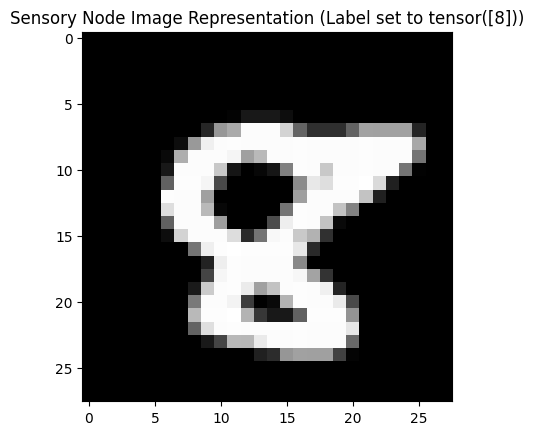

In [11]:
import matplotlib.pyplot as plt

print(len(train_loader))
testing_remove_label = True
testing_remove_data  = False

for batch in train_loader:
    
    # Set the graph-level labels to zero
    # batch.y[:] = 0
    for i in range(len(batch)):
        
        ### batch.x[batch.supervision_indices, :] = 0 
        if testing_remove_label:
            sub_graph = batch[i]  # Access the subgraph
            sub_graph.x[sub_graph.supervision_indices, 0] = torch.zeros_like(sub_graph.x[sub_graph.supervision_indices, 0])  # Check all feature dimensions

    # train_loader.dataset.zero_img_in_graph  = True
    # train_loader.dataset.zero_y_in_graph    = True 

    print(batch)
    print(batch.x.shape)

    batch_item = 1  # Select a specific graph within the batch
    
    sub_graph = batch[batch_item]  # Access the subgraph
    sensory_indices = sub_graph.sensory_indices
    image_tensor = sub_graph.x[sensory_indices, 0].view(28, 28).detach().numpy()
    
    sup_tensor = sub_graph.x[sub_graph.supervision_indices, 0]  # Check all feature dimensions
    
    print("Supervision tensor after zeroing:")
    print(sup_tensor)

    # Display the image
    plt.imshow(image_tensor, cmap='gray')
    plt.title(f"Sensory Node Image Representation (Label set to {sub_graph.y})")

    print("---------------------")
    print("Batched sensory indices:", batch.sensory_indices)
    print("Batched internal indices:", batch.internal_indices)
    print("Batched supervision indices:", batch.supervision_indices)

    print("-------Edge_index (single) vs (batched) ---------")

    single_graph = graph.edge_index
    print(single_graph.shape)
    print(batch.edge_index.shape)

    plt.show()

    break  # Only process the first batch


In [12]:
import matplotlib.pyplot as plt

# batch_size * (784 + 48 + 10)
batch_size * (graph.num_vertices)

print(len(train_loader))

for batch in train_loader:
    print(batch.x.shape)
    
    # Unpack the features along the second dimension
    values, errors, predictions = batch.x[:, 0, :], batch.x[:, 1, :], batch.x[:, 2, :]
    
    print("Values:", values.shape)
    print("Errors:", errors.shape)
    print("Predictions:", predictions.shape)

    batch_size = batch.x.shape[0] // graph.num_vertices
    print(batch_size)
    
    break  # Only process the first batch


25000
torch.Size([1684, 3, 1])
Values: torch.Size([1684, 1])
Errors: torch.Size([1684, 1])
Predictions: torch.Size([1684, 1])
2


In [13]:
# assert 1 == 2 

In [14]:
# from torch_geometric.data import Batch

# for batch in train_loader:
#     batched_data = Batch.from_data_list(batch)
#     print("Node features shape:", batched_data.x.shape)
#     print("Edge index shape:", batched_data.edge_index.shape)
#     break


In [15]:
# from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
# from helper.vanZwol_optim import train_subset_indices, preprocess

# DATASET_PATH = "../data"
# batch_size = 50 

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# train_dataset = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
# test_set = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# train_set, val_set = random_split(train_dataset, [50000, 10000])
# train_indices = train_subset_indices(train_set, 10, no_per_class=0) # if a certain number of samples per class is required, set no_per_class to that number. 0 means all samples are used.

# train_loader = preprocess( DataLoader(train_set, batch_size=batch_size, sampler=SubsetRandomSampler( train_indices ), drop_last=False) ) # subsetrandomsampler shuffles the data.
# val_loader = preprocess( DataLoader(val_set, batch_size=len(val_set), shuffle=False, drop_last=False) )
# test_loader = preprocess( DataLoader(test_set, batch_size=len(test_set), shuffle=False, drop_last=False) )

In [16]:
graph.edge_index.shape[1] * 50

1288000

In [17]:
import torch.nn as nn

values = torch.randn(graph.edge_index.size(1)) * 0.05
w = torch.sparse_coo_tensor(graph.edge_index, values, (graph.num_vertices, graph.num_vertices))
# nn.init.normal_(w, mean=0, std=0.05)  

w.shape

torch.Size([842, 842])

In [18]:
w.coalesce().values().shape

torch.Size([25760])

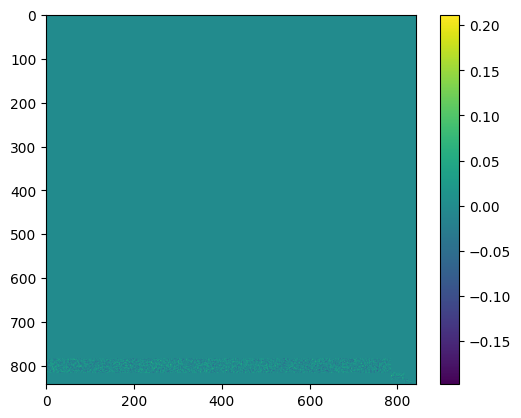

In [19]:
plt.imshow(w.to_dense().cpu().detach())
plt.colorbar()
plt.show()

In [20]:
# from models.PC_vanZwol import PC_graph_zwol 

""" WITH MESSAGE_PASSING """
from models.PC_vanZwolPYG import PC_graph_zwol_PYG

""" WITHOUT MESSAGE_PASSING """
# from models.PC_vanZwol_pyg_loader import PC_graph_zwol_PYG

CUDA available, using GPU


' WITHOUT MESSAGE_PASSING '

In [21]:


from helper.vanZwol_optim import *

# Inference
f = tanh
lr_x = 0.5                  # inference rate 
T_train = 5                 # inference time scale
T_test = 10                 # unused for hierarchical model
incremental = True          # whether to use incremental EM or not
use_input_error = False     # whether to use errors in the input layer or not

# Learning
lr_w = 0.00001              # learning rate
weight_decay = 0             
grad_clip = 1
batch_scale = False
 
import helper.vanZwol_optim as optim


In [22]:
sum(graph.internal_indices)

38760

In [23]:
PCG = PC_graph_zwol_PYG(f,
        device=device,
        num_vertices=graph.num_vertices,
        num_internal=sum(graph.internal_indices),
        adj=adj_matrix_pyg,
        edge_index=graph.edge_index,
        batch_size=batch_size,
        # mask=mask,
        lr_x=lr_x, 
        T_train=T_train,
        T_test=T_test,
        incremental=incremental, 
        use_input_error=use_input_error,
        )

optimizer = optim.Adam(
    PCG.params,
    learning_rate=lr_w,
    grad_clip=grad_clip,
    batch_scale=batch_scale,
    weight_decay=weight_decay,
)
PCG.set_optimizer(optimizer)

PCG.init_modes(batch_example=batch)


model = PCG


------VERSION WITH MESSAGE PASSING-------
settings params
self.dw init None


/home/erencan/UvA/Master Thesis/GraphPredCod2/scr/models/PC_vanZwolPYG.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.update_mask_train = torch.tensor(self.update_mask_train)
/home/erencan/UvA/Master Thesis/GraphPredCod2/scr/models/PC_vanZwolPYG.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.update_mask_test = torch.tensor(self.update_mask_test)


In [24]:
# from torch_geometric.data import Batch

# for batch in train_loader:

#     values = batch.x[:, 0, :]  # Use batched node features directly
#     print(batch.edge_index.shape)

#     print(values.shape)
#     print(values.view(model.batch_size, model.num_vertices).shape)

#     break

In [25]:
print(model.w.cpu().detach().shape,",", model.w.shape[0] * model.w.shape[1])

model.get_sparse_weight().shape

torch.Size([842, 842]) , 708964


torch.Size([25760])

In [26]:
# import torch
# torch.cuda.empty_cache()
# torch.cuda.synchronize()


# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# import gc
# torch.cuda.empty_cache()
# gc.collect()


In [27]:
print(device)

cpu


: 

In [28]:
from tqdm import tqdm
train_energy, train_loss, train_acc = [], [], []
val_loss, val_acc, val_acc2 = [], [], []
num_epochs = 10

with torch.no_grad():
        
    for epochs in tqdm(range(num_epochs)):
        model.train()

        total_loss = 0
        energy = 0
        print("-----train_supervised-----")

        for batch_no, batch in enumerate(train_loader):

            # batch = Batch.from_data_list(batch)

            # batch_graph, batch_label, batch_edge_index = batch.x.to(model.device), batch.y.to(model.device), batch.edge_index.to(model.device)

            batch = batch.to(model.device)
            # Train model on the batch
            model.train_supervised(batch)

            if batch_no >= 50:
                break
            # Compute loss (using last layer as prediction)
            # predictions = model.x[:, -10:]  # Supervision output (assumes 10 classes)
            # loss = criterion(predictions, batch_y)

            # energy += PCG.get_energy()

            # train_energy.append(energy/len(train_loader))

        loss, acc = 0, 0
        print("----test_iterative-----")
        model.test()
        cntr = 0 
        for batch_no, batch in enumerate(val_loader):
            # y_pred = PCG.test_supervised(X_batch) 
            y_batch = batch.y.clone() 

            y_pred = PCG.test_iterative(batch) 
            # loss += MSE(y_pred, onehot(y_batch, N=10) ).item()
            # print("y_pred", y_pred)
            a = y_pred == y_batch
            correct = torch.mean((a).float()).item()
            # print("correct", corret)
            acc += correct

            if batch_no >= 10:
                break
            cntr += 1

        val_acc.append(acc/len(val_loader))
        val_acc2.append(acc/cntr)
        val_loss.append(loss)
        print("val_acc", val_acc)
        print("val_acc2", val_acc2)

        print(f"\nEPOCH {epochs}/{num_epochs} \n #####################")   
        # print(f"VAL acc:   {val_acc[i]:.3f}, VAL MSE:   {val_loss[i]:.3f}, TRAIN ENERGY:   {train_energy[i]:.3f}")

        # if early_stopper.early_stop(val_loss[i]):
        #     print(f"\nEarly stopping at epoch {i+1}")          
        #     break

torch.cuda.empty_cache()



  0%|          | 0/10 [00:00<?, ?it/s]

-----train_supervised-----
self.values 1 shape torch.Size([1684, 1])
edge_index 1 shape torch.Size([2, 51520])
-----------------------------
---get_prediction---
values torch.Size([1684, 1])
edge_weights_batched torch.Size([51520])
self.edge_index torch.Size([2, 51520])


In [ ]:
# make fig bigger
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(model.w.cpu().detach())

___

In [ ]:
from models.PC_vanZwol import PC_graph_zwol

# from 

In [ ]:
device

In [ ]:
from helper.vanZwol_optim import *

# Inference
f = tanh
lr_x = 0.5                  # inference rate 
T_train = 5                 # inference time scale
T_test = 10                 # unused for hierarchical model
incremental = True          # whether to use incremental EM or not
use_input_error = False     # whether to use errors in the input layer or not

# Learning
lr_w = 0.00001              # learning rate
batch_size = 50 
weight_decay = 0             
grad_clip = 1
batch_scale = False
 
import helper.vanZwol_optim as optim

vertices = [784, 48, 10] # input, hidden, output
mask = get_mask_hierarchical([784,32,16,10])

plt.imshow(mask.cpu().detach())

In [ ]:
PCG = PC_graph_zwol(f,
            device=device,
            num_vertices=sum(vertices),
            mask=mask,
            lr_x=lr_x, 
            T_train=T_train,
            T_test=T_test,
            incremental=incremental, 
            use_input_error=use_input_error,
            )

optimizer = optim.Adam(
    PCG.params,
    learning_rate=lr_w,
    grad_clip=grad_clip,
    batch_scale=batch_scale,
    weight_decay=weight_decay,
)
PCG.set_optimizer(optimizer)

In [ ]:
MSE = torch.nn.MSELoss()
from tqdm import tqdm

from datetime import datetime 

train_energy, train_loss, train_acc = [], [], []
val_loss, val_acc = [], []


epochs = 100

start_time = datetime.now()

with torch.no_grad():
    for i in tqdm(range(epochs)):
        
        energy = 0
        for batch_no, (X_batch, y_batch) in enumerate(train_loader):
            PCG.train_supervised(X_batch, y_batch)
            energy += PCG.get_energy()

            if batch_no >= 10:
                break
        train_energy.append(energy/len(train_loader))

        

        loss, acc = 0, 0
        for X_batch, y_batch in val_loader:
            # y_pred = PCG.test_supervised(X_batch) 
            print("----test_iterative-----")
            y_pred = PCG.test_iterative(X_batch) 

            loss += MSE(y_pred, PCG.onehot(y_batch, N=10) ).item()
            a = torch.argmax(y_pred, axis=1) == y_batch
            print("shape", y_batch.shape)
            print("shape", y_pred.shape)
            print("shape", torch.argmax(y_pred, axis=1).shape)
            print("----------------")
            print(torch.argmax(y_pred, axis=1))
            print(y_batch)
            acc += torch.mean((a ).float()).item()

        val_acc.append(acc/len(val_loader))
        val_loss.append(loss)

        print(f"\nEPOCH {i+1}/{epochs} \n #####################")   
        print(f"VAL acc:   {val_acc[i]:.3f}, VAL MSE:   {val_loss[i]:.3f}, TRAIN ENERGY:   {train_energy[i]:.3f}")

print(f"\nTraining time: {datetime.now() - start_time}")


In [ ]:
W = PCG.get_weights().cpu().detach()

plt.imshow(W)
plt.show()

# Learn in stages

In [ ]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)